In [1]:
# Part of the code generated using AI tools such as chatgpt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import CSVLogger

import numpy as np
from matplotlib import pyplot as plt

# Convolutional Neural Network
## CIFAR-10 Image Classification
### 1. DataModule

In image preprocessing, the data is first **normalized** to improve model performance and convergence during training. Normalization typically involves adjusting the pixel values so that they have a consistent scale, often by rescaling them to have a specific mean and standard deviation. 

In this case, the pixel values are transformed such that the mean of the dataset is subtracted from each pixel value, followed by dividing by the standard deviation. This results in pixel values being centered around zero with a unit variance. The formula for this is:

$$
\text{Normalized Value} = \frac{\text{Original Value} - \text{Mean}}{\text{Standard Deviation}}
$$

This normalization helps in speeding up the training process. For images, mean and standard deviation values can either be calculated from the dataset or set to widely-used defaults (e.g., for images in the RGB range, mean values of [0.485, 0.456, 0.406] and standard deviations of [0.229, 0.224, 0.225] are often used for datasets like ImageNet).

```python
# if you get ssh error, try following
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context
```

We will use Lightning DataModule:

In [2]:
#import ssl
#ssl._create_default_https_context = ssl._create_stdlib_context
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, data_dir="~/Downloads/dataset/", batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        # Date Preprcessing
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)
            )
        ])

    def prepare_data(self):
        """Download dataset (only once)."""
        datasets.CIFAR10(root=self.data_dir, train=True, download=True)
        datasets.CIFAR10(root=self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        """Split train/validation and prepare test set."""
        full_train = datasets.CIFAR10(root=self.data_dir, train=True, transform=self.transform)
        self.train_ds, self.val_ds = random_split(full_train, [45000, 5000])
        self.test_ds = datasets.CIFAR10(root=self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=2)

    def show_samples(self, num_images=8):
        """Display a few images from the training set."""
        loader = DataLoader(self.train_ds, batch_size=num_images, shuffle=True)
        images, labels = next(iter(loader))

        # Undo normalization for visualization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        images = images * std + mean  # denormalize

        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
        for i in range(num_images):
            img = images[i].permute(1, 2, 0).numpy()
            axes[i].imshow(np.clip(img, 0, 1))
            axes[i].axis('off')
        plt.show()

Files already downloaded and verified
Files already downloaded and verified


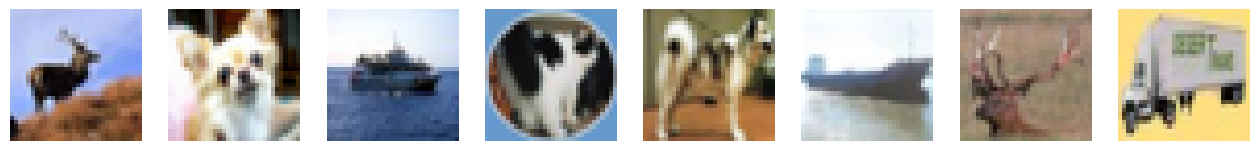

In [3]:
# show some sample images
dm = CIFAR10DataModule(batch_size=64)
dm.prepare_data()
dm.setup()
dm.show_samples(num_images=8)

### 2. CNN Model

In [12]:
# -----------------------------
# CNN Model (LightningModule)
# -----------------------------
class MyFirstCnnModel(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.criteria = nn.CrossEntropyLoss()

        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1), # parameter: 32*3x3X3 + 32, output: 32x32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1), # parameter: 64*3x3x32 + 64, output: 32x32x64
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 16x16x64  [(N-F+2P)/S + 1, (32-2)/2 + 1]

            nn.Conv2d(64, 128, 3, stride=1, padding=1), # parameter: 128*3x3x64 + 128, output: 32x32x128
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 8x8x128

            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256), #parameters: 256*128*8*8 + 128
            nn.ReLU(),
            nn.Linear(256, 10), # parameters: 10*256 + 10
            
        )

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criteria(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criteria(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        return [optimizer], [scheduler]

### 3. Train the network 

In [17]:
# -----------------------------
# Training
# -----------------------------
data_module = CIFAR10DataModule(batch_size=128)
model = MyFirstCnnModel(lr=1e-3)

csv_logger = CSVLogger(".logs", name="cifar10_experiment")
trainer = pl.Trainer(
    max_epochs=2,
    accelerator="auto", # pick the best hardware
    log_every_n_steps=100,
    logger=csv_logger
)
trainer.fit(model, datamodule=data_module)

metrics = trainer.logged_metrics
print(metrics)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | criteria | CrossEntropyLoss | 0      | train
1 | network  | Sequential       | 2.2 M  | train
------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.773     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                      | 0/? [00:00<?, ?it/s]

Training: |                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


{'train_loss': tensor(0.7743), 'train_acc': tensor(0.6389), 'val_loss': tensor(0.8135), 'val_acc': tensor(0.7192)}


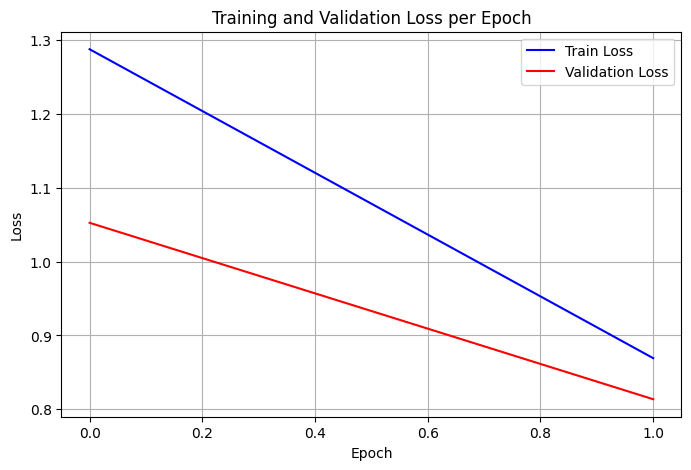

In [18]:
import csv
import matplotlib.pyplot as plt
from collections import defaultdict

metrics_path = csv_logger.experiment.metrics_file_path

# Store losses grouped by epoch
epoch_train, epoch_val = defaultdict(list), defaultdict(list)

with open(metrics_path, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        if "epoch" in row and row["epoch"].isdigit():
            epoch = int(row["epoch"])
            if "train_loss" in row and row["train_loss"]:
                epoch_train[epoch].append(float(row["train_loss"]))
            if "val_loss" in row and row["val_loss"]:
                epoch_val[epoch].append(float(row["val_loss"]))

# Average per epoch
epochs = sorted(set(epoch_train.keys()) | set(epoch_val.keys()))
train_loss = [sum(epoch_train[e]) / len(epoch_train[e]) if e in epoch_train else None for e in epochs]
val_loss = [sum(epoch_val[e]) / len(epoch_val[e]) if e in epoch_val else None for e in epochs]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Train Loss", color="blue")
plt.plot(epochs, val_loss, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()


### 4. Validate on test set

✅ Test Accuracy: 71.83%
Actual: cat | Predicted: cat
Actual: ship | Predicted: automobile
Actual: ship | Predicted: ship
Actual: airplane | Predicted: airplane
Actual: frog | Predicted: frog
Actual: frog | Predicted: frog
Actual: automobile | Predicted: automobile
Actual: frog | Predicted: deer
Actual: cat | Predicted: cat
Actual: automobile | Predicted: automobile


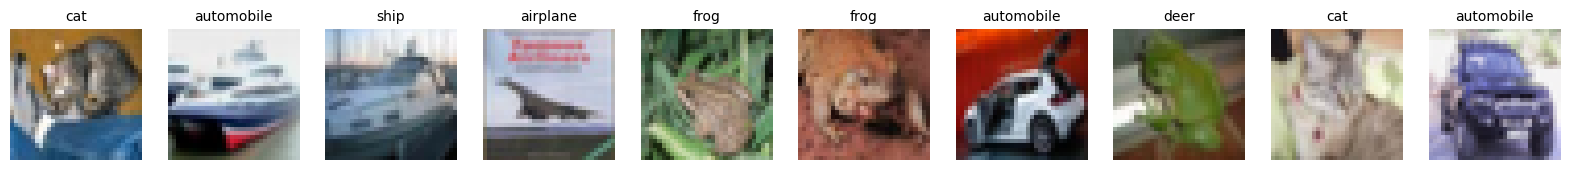

In [19]:
# -----------------------------
# Test evaluation and visualization
# -----------------------------
# Put model in eval mode
model.eval()

# Get test dataloader from the data module
test_loader = data_module.test_dataloader()

# Evaluate test accuracy
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(model.device), labels.to(model.device)
        outputs = model(images)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total * 100
print(f"✅ Test Accuracy: {test_acc:.2f}%")

# -----------------------------
# Show example predictions
# -----------------------------
images, labels = next(iter(test_loader))
images, labels = images.to(model.device), labels.to(model.device)
outputs = model(images)
_, predicted = torch.max(outputs, dim=1)

# Get CIFAR-10 class names
class_names = data_module.test_ds.classes

# Undo normalization for visualization
mean = torch.tensor([0.485, 0.456, 0.406], device=images.device).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], device=images.device).view(3, 1, 1)
images = images * std + mean  # unnormalize

# Show 10 examples
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    img = images[i].permute(1, 2, 0).cpu().numpy()
    plt.imshow(np.clip(img, 0, 1))
    plt.axis("off")
    plt.title(class_names[predicted[i].item()], fontsize=10)
    print(f"Actual: {class_names[labels[i].item()]} | Predicted: {class_names[predicted[i].item()]}")
plt.show()